<a href="https://colab.research.google.com/github/jmamath/Bottom-Sea-Detection/blob/master/Variational_Inference_with_Normalizing_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Inference with Normalizing Flows

Code distilled from https://github.com/riannevdberg/sylvester-flows .

In [0]:
# IMPORTS AND MAGICS

%matplotlib inline

import math
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# TODO: Can we remove this?
from torch.autograd import Variable

In [0]:
# CONFIGURATION FOR EXPERIMENTS

epochs = 5
batch_size = 100
input_size = [1, 28, 28]
learning_rate = 0.0005

In [0]:
!wget https://raw.githubusercontent.com/riannevdberg/sylvester-flows/master/data/MNIST_static/binarized_mnist_train.amat
!wget https://raw.githubusercontent.com/riannevdberg/sylvester-flows/master/data/MNIST_static/binarized_mnist_test.amat
!wget https://raw.githubusercontent.com/riannevdberg/sylvester-flows/master/data/MNIST_static/binarized_mnist_valid.amat
!ls

--2019-10-29 19:47:26--  https://raw.githubusercontent.com/riannevdberg/sylvester-flows/master/data/MNIST_static/binarized_mnist_train.amat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78400000 (75M) [text/plain]
Saving to: ‘binarized_mnist_train.amat’

binarized_mnist_tra 100%[===================>]  74.77M   235MB/s    in 0.3s    

2019-10-29 19:47:28 (235 MB/s) - ‘binarized_mnist_train.amat’ saved [78400000/78400000]

--2019-10-29 19:47:31--  https://raw.githubusercontent.com/riannevdberg/sylvester-flows/master/data/MNIST_static/binarized_mnist_valid.amat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443.

In [0]:
# CODE FOR LOADING MNIST DATA INTO DATALOADERS

def load_static_mnist():
    """
    Dataloading function for static mnist. Outputs image data in vectorized form: each image is a vector of size 784
    """

    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])

    with open('binarized_mnist_train.amat') as f:
        lines = f.readlines()
    x_train = lines_to_np_array(lines).astype('float32')
    with open('binarized_mnist_valid.amat') as f:
        lines = f.readlines()
    x_val = lines_to_np_array(lines).astype('float32')
    with open('binarized_mnist_test.amat') as f:
        lines = f.readlines()
    x_test = lines_to_np_array(lines).astype('float32')

    # shuffle train data
    # Is this necessary, with the shuffle keyword in the train_loader?
    np.random.shuffle(x_train)

    # idle y's
    y_train = np.zeros((x_train.shape[0], 1))
    y_val = np.zeros((x_val.shape[0], 1))
    y_test = np.zeros((x_test.shape[0], 1))

    # pytorch data loader
    train = data_utils.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

    validation = data_utils.TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val))
    val_loader = data_utils.DataLoader(validation, batch_size=batch_size, shuffle=False)

    test = data_utils.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test))
    test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [0]:
# PERFORM THE DATA LOADING

train_loader, val_loader, test_loader = load_static_mnist()

In [0]:
#DEFINES GATED CONVOLUTIONAL AND DECONVOLUTIONAL LAYERS USED IN THE VAE

# TODO: Remove the gates!

class GatedConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, padding, dilation=1, activation=None):
        super(GatedConv2d, self).__init__()

        self.activation = activation
        self.sigmoid = nn.Sigmoid()

        self.h = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, dilation)
        self.g = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, dilation)

    def forward(self, x):
        if self.activation is None:
            h = self.h(x)
        else:
            h = self.activation(self.h(x))

        g = self.sigmoid(self.g(x))

        return h * g


class GatedConvTranspose2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, padding, output_padding=0, dilation=1,
                 activation=None):
        super(GatedConvTranspose2d, self).__init__()

        self.activation = activation
        self.sigmoid = nn.Sigmoid()

        self.h = nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, output_padding,
                                    dilation=dilation)
        self.g = nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, output_padding,
                                    dilation=dilation)

    def forward(self, x):
        if self.activation is None:
            h = self.h(x)
        else:
            h = self.activation(self.h(x))

        g = self.sigmoid(self.g(x))

        return h * g


In [0]:
# DEFINES A PLANAR FLOW LAYER, THE VAE MODEL, AND THE VAE MODEL WITH NORMALIZING FLOWS

num_flows = 4

class Planar(nn.Module):
    """
    PyTorch implementation of planar flows as presented in "Variational Inference with Normalizing Flows"
    by Danilo Jimenez Rezende, Shakir Mohamed. Model assumes amortized flow parameters.
    """

    def __init__(self):

        super(Planar, self).__init__()

        self.h = nn.Tanh()
        self.softplus = nn.Softplus()

    def der_h(self, x):
        """ Derivative of tanh """

        return 1 - self.h(x) ** 2

    def forward(self, zk, u, w, b):
        """
        Forward pass. Assumes amortized u, w and b. Conditions on diagonals of u and w for invertibility
        will be be satisfied inside this function. Computes the following transformation:
        z' = z + u h( w^T z + b)
        or actually
        z'^T = z^T + h(z^T w + b)u^T
        Assumes the following input shapes:
        shape u = (batch_size, z_size, 1)
        shape w = (batch_size, 1, z_size)
        shape b = (batch_size, 1, 1)
        shape z = (batch_size, z_size).
        """

        zk = zk.unsqueeze(2)

        # reparameterize u such that the flow becomes invertible (see appendix paper)
        uw = torch.bmm(w, u)
        m_uw = -1. + self.softplus(uw)
        w_norm_sq = torch.sum(w ** 2, dim=2, keepdim=True)
        u_hat = u + ((m_uw - uw) * w.transpose(2, 1) / w_norm_sq)

        # compute flow with u_hat
        wzb = torch.bmm(w, zk) + b
        z = zk + u_hat * self.h(wzb)
        z = z.squeeze(2)

        # compute logdetJ
        psi = w * self.der_h(wzb)
        log_det_jacobian = torch.log(torch.abs(1 + torch.bmm(psi, u_hat)))
        log_det_jacobian = log_det_jacobian.squeeze(2).squeeze(1)

        return z, log_det_jacobian

class VAE(nn.Module):
    """
    The base VAE class containing gated convolutional encoder and decoder architecture.
    Can be used as a base class for VAE's with normalizing flows.
    """

    def __init__(self):
        super(VAE, self).__init__()

        # extract model settings from args
        self.z_size = 64
        self.input_size = [1, 28, 28]
        self.last_kernel_size = 7

        self.q_z_nn, self.q_z_mean, self.q_z_var = self.create_encoder()
        self.p_x_nn, self.p_x_mean = self.create_decoder()
        self.q_z_nn_output_dim = 256

        self.FloatTensor = torch.cuda.FloatTensor
        # log-det-jacobian = 0 without flows
        self.log_det_j = Variable(self.FloatTensor(1).zero_())

    def create_encoder(self):
        """
        Helper function to create the elemental blocks for the encoder. Creates a gated convnet encoder.
        the encoder expects data as input of shape (batch_size, num_channels, width, height).
        """

        # TODO: Replace these layers?
        q_z_nn = nn.Sequential(
            GatedConv2d(self.input_size[0], 32, 5, 1, 2),
            GatedConv2d(32, 32, 5, 2, 2),
            GatedConv2d(32, 64, 5, 1, 2),
            GatedConv2d(64, 64, 5, 2, 2),
            GatedConv2d(64, 64, 5, 1, 2),
            GatedConv2d(64, 256, self.last_kernel_size, 1, 0),
        )
        q_z_mean = nn.Linear(256, self.z_size)
        q_z_var = nn.Sequential(
            nn.Linear(256, self.z_size),
            nn.Softplus(),
        )
        return q_z_nn, q_z_mean, q_z_var

    def create_decoder(self):
        """
        Helper function to create the elemental blocks for the decoder. Creates a gated convnet decoder.
        """

        # TODO: Replace these layers?
        p_x_nn = nn.Sequential(
            GatedConvTranspose2d(self.z_size, 64, self.last_kernel_size, 1, 0),
            GatedConvTranspose2d(64, 64, 5, 1, 2),
            GatedConvTranspose2d(64, 32, 5, 2, 2, 1),
            GatedConvTranspose2d(32, 32, 5, 1, 2),
            GatedConvTranspose2d(32, 32, 5, 2, 2, 1),
            GatedConvTranspose2d(32, 32, 5, 1, 2)
        )

        p_x_mean = nn.Sequential(
            nn.Conv2d(32, self.input_size[0], 1, 1, 0),
            nn.Sigmoid()
        )
        return p_x_nn, p_x_mean


    def reparameterize(self, mu, var):
        """
        Samples z from a multivariate Gaussian with diagonal covariance matrix using the
         reparameterization trick.
        """

        std = var.sqrt()
        eps = self.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        z = eps.mul(std).add_(mu)
        return z

    def encode(self, x):
        """
        Encoder expects following data shapes as input: shape = (batch_size, num_channels, width, height)
        """

        h = self.q_z_nn(x)
        h = h.view(h.size(0), -1)
        mean = self.q_z_mean(h)
        var = self.q_z_var(h)
        return mean, var

    def decode(self, z):
        """
        Decoder outputs reconstructed image in the following shapes:
        x_mean.shape = (batch_size, num_channels, width, height)
        """

        z = z.view(z.size(0), self.z_size, 1, 1)
        h = self.p_x_nn(z)
        x_mean = self.p_x_mean(h)
        return x_mean

    def forward(self, x):
        """
        Evaluates the model as a whole, encodes and decodes. Note that the log det jacobian is zero
         for a plain VAE (without flows), and z_0 = z_k.
        """

        # mean and variance of z
        z_mu, z_var = self.encode(x)
        # sample z
        z = self.reparameterize(z_mu, z_var)
        x_mean = self.decode(z)
        return x_mean, z_mu, z_var, self.log_det_j, z, z


class PlanarVAE(VAE):
    """
    Variational auto-encoder with planar flows in the encoder.
    """

    def __init__(self):
        super(PlanarVAE, self).__init__()

        # Initialize log-det-jacobian to zero
        self.log_det_j = 0.

        # Flow parameters
        self.num_flows = num_flows

        # Amortized flow parameters
        self.amor_u = nn.Linear(self.q_z_nn_output_dim, self.num_flows * self.z_size)
        self.amor_w = nn.Linear(self.q_z_nn_output_dim, self.num_flows * self.z_size)
        self.amor_b = nn.Linear(self.q_z_nn_output_dim, self.num_flows)

        # Normalizing flow layers
        for k in range(self.num_flows):
            flow_k = Planar()
            self.add_module('flow_' + str(k), flow_k)

    def encode(self, x):
        """
        Encoder that ouputs parameters for base distribution of z and flow parameters.
        """

        batch_size = x.size(0)

        h = self.q_z_nn(x)
        h = h.view(-1, self.q_z_nn_output_dim)
        mean_z = self.q_z_mean(h)
        var_z = self.q_z_var(h)

        # return amortized u an w for all flows
        u = self.amor_u(h).view(batch_size, self.num_flows, self.z_size, 1)
        w = self.amor_w(h).view(batch_size, self.num_flows, 1, self.z_size)
        b = self.amor_b(h).view(batch_size, self.num_flows, 1, 1)

        return mean_z, var_z, u, w, b

    def forward(self, x):
        """
        Forward pass with planar flows for the transformation z_0 -> z_1 -> ... -> z_k.
        Log determinant is computed as log_det_j = N E_q_z0[\sum_k log |det dz_k/dz_k-1| ].
        """

        self.log_det_j = 0.

        z_mu, z_var, u, w, b = self.encode(x)

        # Sample z_0
        z = [self.reparameterize(z_mu, z_var)]

        # Normalizing flows
        for k in range(self.num_flows):
            flow_k = getattr(self, 'flow_' + str(k))
            z_k, log_det_jacobian = flow_k(z[k], u[:, k, :, :], w[:, k, :, :], b[:, k, :, :])
            z.append(z_k)
            self.log_det_j += log_det_jacobian

        x_mean = self.decode(z[-1])

        return x_mean, z_mu, z_var, self.log_det_j, z[0], z[-1]


In [0]:
# CODE FOR CALCULATING THE MODEL LOSS

def log_normal_diag(x, mean, log_var, average=False, reduce=True, dim=None):
    log_norm = -0.5 * (log_var + (x - mean) * (x - mean) * log_var.exp().reciprocal())
    if reduce:
        if average:
            return torch.mean(log_norm, dim)
        else:
            return torch.sum(log_norm, dim)
    else:
        return log_norm

def log_normal_standard(x, average=False, reduce=True, dim=None):
    log_norm = -0.5 * x * x

    if reduce:
        if average:
            return torch.mean(log_norm, dim)
        else:
            return torch.sum(log_norm, dim)
    else:
        return log_norm

def binary_loss_function(recon_x, x, z_mu, z_var, z_0, z_k, ldj, beta=1.):
    """
    Computes the binary loss function while summing over batch dimension, not averaged!
    :param recon_x: shape: (batch_size, num_channels, pixel_width, pixel_height), bernoulli parameters p(x=1)
    :param x: shape (batchsize, num_channels, pixel_width, pixel_height), pixel values rescaled between [0, 1].
    :param z_mu: mean of z_0
    :param z_var: variance of z_0
    :param z_0: first stochastic latent variable
    :param z_k: last stochastic latent variable
    :param ldj: log det jacobian
    :param beta: beta for kl loss
    :return: loss, ce, kl
    """

    # TODO: See Rianne warning about this on github page/README!
    reconstruction_function = nn.BCELoss(reduction='sum')

    batch_size = x.size(0)

    # - N E_q0 [ ln p(x|z_k) ]
    bce = reconstruction_function(recon_x, x)

    # ln p(z_k)  (not averaged)
    log_p_zk = log_normal_standard(z_k, dim=1)
    # ln q(z_0)  (not averaged)
    log_q_z0 = log_normal_diag(z_0, mean=z_mu, log_var=z_var.log(), dim=1)
    # N E_q0[ ln q(z_0) - ln p(z_k) ]
    summed_logs = torch.sum(log_q_z0 - log_p_zk)

    # sum over batches
    summed_ldj = torch.sum(ldj)

    # ldj = N E_q_z0[\sum_k log |det dz_k/dz_k-1| ]
    kl = (summed_logs - summed_ldj)
    loss = bce + beta * kl

    loss = loss / float(batch_size)
    bce = bce / float(batch_size)
    kl = kl / float(batch_size)

    return loss, bce, kl

def calculate_loss(x_mean, x, z_mu, z_var, z_0, z_k, ldj, beta=1.):
    # TODO: Remove this layer of indirection
    # TODO: Remove bpd stuff?
    loss, rec, kl = binary_loss_function(x_mean, x, z_mu, z_var, z_0, z_k, ldj, beta=beta)
    bpd = 0.
    return loss, rec, kl, bpd



In [0]:
# CODE FOR PLOTTING RECONSTRUCTIONS

def plot_reconstructions(data, recon_mean, loss, loss_type, epoch):

    # TODO: Remove this layer of indirection
    # VISUALIZATION: plot reconstructions
    plot_images(recon_mean.data.cpu().numpy()[0:9], size_x=3, size_y=3)

def plot_images(x_sample, size_x=3, size_y=3):

    fig = plt.figure(figsize=(size_x, size_y))
    # fig = plt.figure(1)
    gs = gridspec.GridSpec(size_x, size_y)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(x_sample):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        sample = sample.reshape((input_size[0], input_size[1], input_size[2]))
        sample = sample.swapaxes(0, 2)
        sample = sample.swapaxes(0, 1)
        sample = sample[:, :, 0]
        plt.imshow(sample, cmap='gray', vmin=0, vmax=1)

In [0]:
# CODE FOR ONE TRAINING EPOCH, AND EVALUATING MODEL ON VALIDATION SET

log_interval = 10

def train(epoch, train_loader, model, opt):

    model.train()
    train_loss = np.zeros(len(train_loader))
    # TODO: remove bpds?
    train_bpd = np.zeros(len(train_loader))
    num_data = 0

    beta = 1
    # TODO - omit for now? set warmup coefficient
    #beta = min([(epoch * 1.) / max([args.warmup, 1.]), args.max_beta])
    #print('beta = {:5.4f}'.format(beta))

    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.cuda()
        data = Variable(data)
        data = data.view(-1, *input_size) # was *args.input_size

        opt.zero_grad()
        x_mean, z_mu, z_var, ldj, z0, zk = model(data)
        loss, rec, kl, bpd = calculate_loss(x_mean, data, z_mu, z_var, z0, zk, ldj, beta=beta)

        loss.backward()
        train_loss[batch_idx] = loss.item()
        train_bpd[batch_idx] = bpd

        opt.step()

        rec = rec.item()
        kl = kl.item()
        num_data += len(data)

        if batch_idx % log_interval == 0:
            print('Epoch: {:3d} [{:5d}/{:5d} ({:2.0f}%)]  \tLoss: {:11.6f}\trec: {:11.6f}\tkl: {:11.6f}'.format(
                epoch, num_data, len(train_loader.sampler), 100. * batch_idx / len(train_loader),
                loss.item(), rec, kl))

    print('====> Epoch: {:3d} Average train loss: {:.4f}'.format(
        epoch, train_loss.sum() / len(train_loader)))

    return train_loss

def evaluate(data_loader, model, testing=False, file=None, epoch=0):
    model.eval()
    loss = 0.
    batch_idx = 0

    loss_type = 'elbo'

    for data, _ in data_loader:
        batch_idx += 1

        data = data.cuda()
        data = Variable(data, volatile=True)
        data = data.view(-1, *input_size)  # was *args.input_size

        x_mean, z_mu, z_var, ldj, z0, zk = model(data)
        batch_loss, rec, kl, batch_bpd = calculate_loss(x_mean, data, z_mu, z_var, z0, zk, ldj)

        loss += batch_loss.item()

        # PRINT RECONSTRUCTIONS
        if batch_idx == 1 and testing is False:
            plot_reconstructions(data, x_mean, batch_loss, loss_type, epoch)

    loss /= len(data_loader)

    print('====> Validation set loss: {:.4f}'.format(loss))
    return loss


Epoch:   1 [  100/50000 ( 0%)]  	Loss:  522.901123	rec:  520.206238	kl:    2.694899
Epoch:   1 [ 1100/50000 ( 2%)]  	Loss:  497.275848	rec:  495.856750	kl:    1.419106
Epoch:   1 [ 2100/50000 ( 4%)]  	Loss:  441.060303	rec:  439.794434	kl:    1.265873
Epoch:   1 [ 3100/50000 ( 6%)]  	Loss:  373.652618	rec:  372.515228	kl:    1.137388
Epoch:   1 [ 4100/50000 ( 8%)]  	Loss:  362.803619	rec:  361.209839	kl:    1.593801
Epoch:   1 [ 5100/50000 (10%)]  	Loss:  360.609497	rec:  358.847778	kl:    1.761718
Epoch:   1 [ 6100/50000 (12%)]  	Loss:  343.779602	rec:  341.990631	kl:    1.788982
Epoch:   1 [ 7100/50000 (14%)]  	Loss:  291.174561	rec:  276.834198	kl:   14.340358
Epoch:   1 [ 8100/50000 (16%)]  	Loss:  260.165039	rec:  254.507599	kl:    5.657463
Epoch:   1 [ 9100/50000 (18%)]  	Loss:  262.564453	rec:  255.802383	kl:    6.762095
Epoch:   1 [10100/50000 (20%)]  	Loss:  240.677048	rec:  233.740387	kl:    6.936654
Epoch:   1 [11100/50000 (22%)]  	Loss:  235.592041	rec:  228.108780	kl:    7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


====> Validation set loss: 183.5102
Finished epoch 1

====> Validation set loss: 183.5349
EVALUATION ON VALIDATION SET
ELBO (VAL): 183.5349

Epoch:   2 [  100/50000 ( 0%)]  	Loss:  179.366364	rec:  171.712402	kl:    7.653964
Epoch:   2 [ 1100/50000 ( 2%)]  	Loss:  192.117676	rec:  184.065460	kl:    8.052215
Epoch:   2 [ 2100/50000 ( 4%)]  	Loss:  183.080841	rec:  175.561111	kl:    7.519727
Epoch:   2 [ 3100/50000 ( 6%)]  	Loss:  180.340622	rec:  171.332458	kl:    9.008164
Epoch:   2 [ 4100/50000 ( 8%)]  	Loss:  182.084015	rec:  173.631790	kl:    8.452228
Epoch:   2 [ 5100/50000 (10%)]  	Loss:  180.093719	rec:  170.394135	kl:    9.699581
Epoch:   2 [ 6100/50000 (12%)]  	Loss:  176.835449	rec:  166.155930	kl:   10.679504
Epoch:   2 [ 7100/50000 (14%)]  	Loss:  178.583115	rec:  168.606171	kl:    9.976950
Epoch:   2 [ 8100/50000 (16%)]  	Loss:  166.918625	rec:  156.708740	kl:   10.209888
Epoch:   2 [ 9100/50000 (18%)]  	Loss:  175.075836	rec:  165.877792	kl:    9.198054
Epoch:   2 [10100/5

NameError: ignored

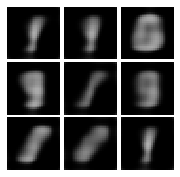

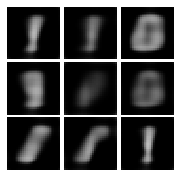

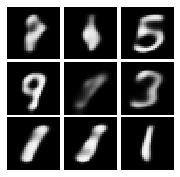

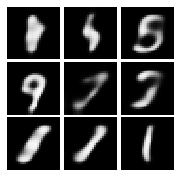

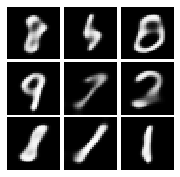

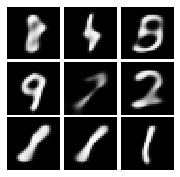

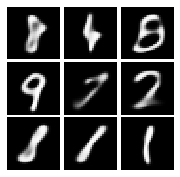

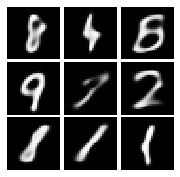

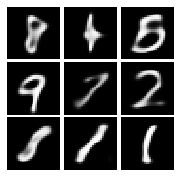

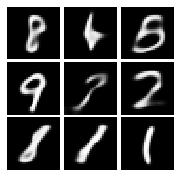

In [0]:
# MAIN TRAINING LOOP

#model = VAE()
model = PlanarVAE()
model.cuda()

# TODO: use default settings?
optimizer = optim.Adamax(model.parameters(), lr=learning_rate, eps=1.e-7)
train_loss = []
val_loss = []
epoch = 0

for epoch in range(1, epochs + 1):
    tr_loss = train(epoch, train_loader, model, optimizer)
    train_loss.append(tr_loss)
    v_loss = evaluate(val_loader, model, epoch=epoch)
    val_loss.append(v_loss)
    print('Finished epoch {}\n'.format(epoch))
    validation_loss = evaluate(val_loader, model)
    print('EVALUATION ON VALIDATION SET\n'
                'ELBO (VAL): {:.4f}\n'.format(validation_loss))

    if math.isnan(v_loss):
        raise ValueError('NaN encountered!')

train_loss = np.hstack(train_loss)
val_loss = np.array(val_loss)
validation_loss = evaluate(val_loader, model, args)
print('FINAL EVALUATION ON VALIDATION SET\n'
                  'ELBO (VAL): {:.4f}\n'.format(validation_loss))

run(args, kwargs)
